In [1]:
import time
import requests
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Fix for module imports if notebook is in root
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

# Import your custom classes
from tester.TodoTester import TodoTester
from tester.ProjectTester import ProjectTester

# Configuration
API_URL = "http://localhost:4567"
LOAD_LEVELS = [10, 500, 1000, 2000, 4000, 8000, 10000]
# LOAD_LEVELS = [10, 50, 100]

print("Imports complete. Configuration loaded.")

Imports complete. Configuration loaded.


In [2]:
try:
    requests.get(f"{API_URL}/todos", timeout=2)
    print(f"✅ Target API is online at {API_URL}")
except requests.RequestException:
    print(f"❌ Error: Could not connect to {API_URL}")
    print("   Please ensure the Part A server is running.")
    # Stop execution if server is down
    raise RuntimeError("Server not reachable")

✅ Target API is online at http://localhost:4567


In [3]:
# Instantiate testers
testers = [
    ("Todo", TodoTester(API_URL)),
    ("Project", ProjectTester(API_URL))
]

all_results = []

print("🚀 Starting Performance Tests...\n")

for name, tester in testers:
    print(f"--- Testing Object Type: {name} ---")
    
    for load in LOAD_LEVELS:
        # Run experiment
        result = tester.run_experiment(load)
        
        # Tag the result
        result['type'] = name 
        all_results.append(result)
        
        # Cool-down to ensure CPU baseline resets
        time.sleep(1)

print("\n✅ Experiments Completed.")

🚀 Starting Performance Tests...

--- Testing Object Type: Todo ---

--- Starting Experiment (todos): Load = 10 objects ---
Results for todos (10 objects):
  [Create] Time: 0.0352s | CPU: 0.0% | RAM: 4518.32MB
  [Update] Time: 0.0652s | CPU: 0.0% | RAM: 4525.63MB
  [Delete] Time: 0.0518s | CPU: 0.0% | RAM: 4543.51MB

--- Starting Experiment (todos): Load = 500 objects ---
Results for todos (500 objects):
  [Create] Time: 1.7784s | CPU: 68.67% | RAM: 4484.27MB
  [Update] Time: 2.6322s | CPU: 66.51% | RAM: 4466.39MB
  [Delete] Time: 3.6395s | CPU: 71.0% | RAM: 4480.12MB

--- Starting Experiment (todos): Load = 1000 objects ---
Results for todos (1000 objects):
  [Create] Time: 4.4428s | CPU: 79.98% | RAM: 4165.5MB
  [Update] Time: 5.3654s | CPU: 67.26% | RAM: 4177.47MB
  [Delete] Time: 7.2846s | CPU: 69.25% | RAM: 4183.59MB

--- Starting Experiment (todos): Load = 2000 objects ---
Results for todos (2000 objects):
  [Create] Time: 7.5978s | CPU: 66.96% | RAM: 4221.98MB
  [Update] Time: 11

In [4]:
# Convert results to a Pandas DataFrame
df = pd.DataFrame(all_results)

# Define the new column order to include the per-operation metrics
cols = [
    'type', 'load_count', 
    'create_time_sec', 'create_cpu_avg', 'create_ram_avg',
    'update_time_sec', 'update_cpu_avg', 'update_ram_avg',
    'delete_time_sec', 'delete_cpu_avg', 'delete_ram_avg'
]

# Select only these columns
df = df[cols]

# Rename columns for a cleaner display table
display_df = df.rename(columns={
    'type': 'Type',
    'load_count': 'Load',
    
    # Create Phase
    'create_time_sec': 'Create (s)',
    'create_cpu_avg': 'Create CPU (%)',
    'create_ram_avg': 'Create Free RAM (MB)',
    
    # Update Phase
    'update_time_sec': 'Update (s)',
    'update_cpu_avg': 'Update CPU (%)',
    'update_ram_avg': 'Update Free RAM (MB)',
    
    # Delete Phase
    'delete_time_sec': 'Delete (s)',
    'delete_cpu_avg': 'Delete CPU (%)',
    'delete_ram_avg': 'Delete Free RAM (MB)'
})

# Display the table
display(display_df)

,Type,Load,Create (s),Create CPU (%),Create Free RAM (MB),Update (s),Update CPU (%),Update Free RAM (MB),Delete (s),Delete CPU (%),Delete Free RAM (MB)
0,Todo,10,0.0352,0.00,4518.32,0.0652,0.00,4525.63,0.0518,0.00,4543.51
1,Todo,500,1.7784,68.67,4484.27,2.6322,66.51,4466.39,3.6395,71.00,4480.12
2,Todo,1000,4.4428,79.98,4165.50,5.3654,67.26,4177.47,7.2846,69.25,4183.59
3,Todo,2000,7.5978,66.96,4221.98,11.1571,66.38,4209.44,13.9463,67.11,4237.19
4,Todo,4000,15.1054,69.37,4039.70,23.1550,68.17,4020.36,26.4329,67.29,3945.68
5,Todo,8000,36.3396,68.10,3935.89,46.0986,67.65,3757.80,54.7713,68.58,3847.61
6,Todo,10000,41.7527,67.87,3914.62,58.2914,66.75,3867.21,91.2749,72.79,4821.17
7,Project,10,0.0268,0.00,5601.48,0.0340,0.00,5612.50,0.0346,0.00,5592.16
8,Project,500,1.6530,67.91,5565.97,1.9624,64.41,5560.32,2.3949,70.65,5557.71
9,Project,1000,3.4324,68.76,5599.91,4.0346,63.64,5606.00,4.5450,63.75,5613.89


In [5]:
# # Setup the plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# # Filter data by type
# todo_data = df[df['type'] == 'Todo']
# proj_data = df[df['type'] == 'Project']

# # --- Plot 1: Execution Time (Create Operation) ---
# ax1.plot(todo_data['load_count'], todo_data['create_time_sec'], marker='o', label='Todo Create', color='blue')
# ax1.plot(proj_data['load_count'], proj_data['create_time_sec'], marker='s', label='Project Create', color='green', linestyle='--')

# ax1.set_title("Scalability: Create Time vs Load")
# ax1.set_xlabel("Number of Objects")
# ax1.set_ylabel("Time (Seconds)")
# ax1.grid(True, alpha=0.3)
# ax1.legend()

# # --- Plot 2: CPU Impact ---
# width = 0.35
# x = range(len(LOAD_LEVELS))

# ax2.bar([i - width/2 for i in x], todo_data['rel_cpu_increase'], width, label='Todo', color='blue', alpha=0.7)
# ax2.bar([i + width/2 for i in x], proj_data['rel_cpu_increase'], width, label='Project', color='green', alpha=0.7)

# ax2.set_title("Relative CPU Cost vs Load")
# ax2.set_xlabel("Load Level")
# ax2.set_ylabel("CPU Increase (%)")
# ax2.set_xticks(x)
# ax2.set_xticklabels(LOAD_LEVELS)
# ax2.grid(axis='y', alpha=0.3)
# ax2.legend()

# plt.tight_layout()
# plt.show()

--- Generating Plots for Todo ---


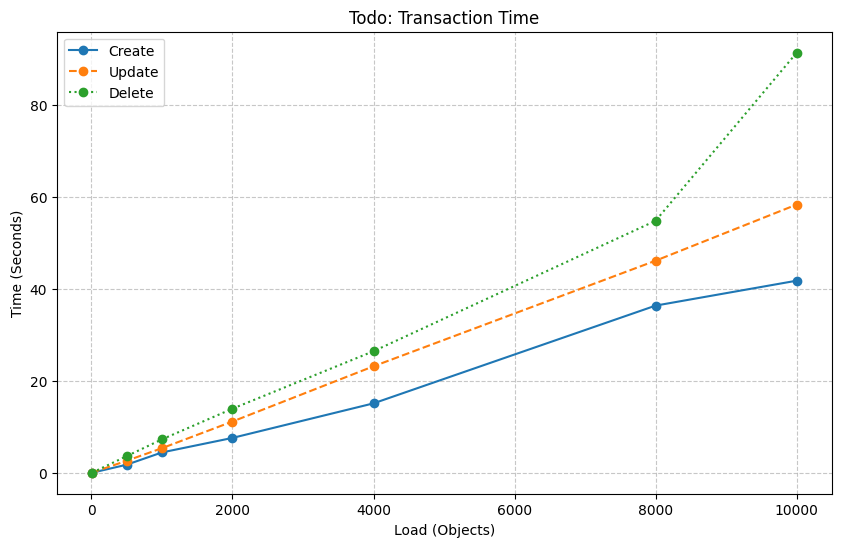

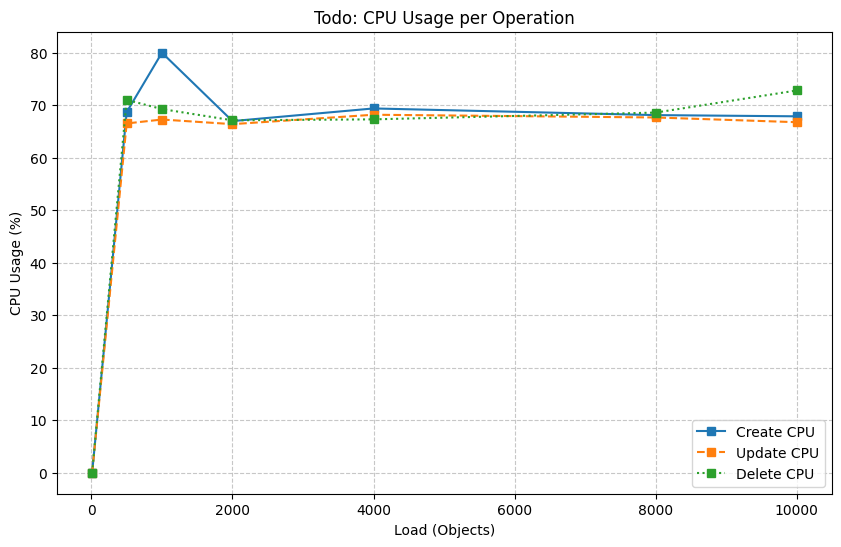

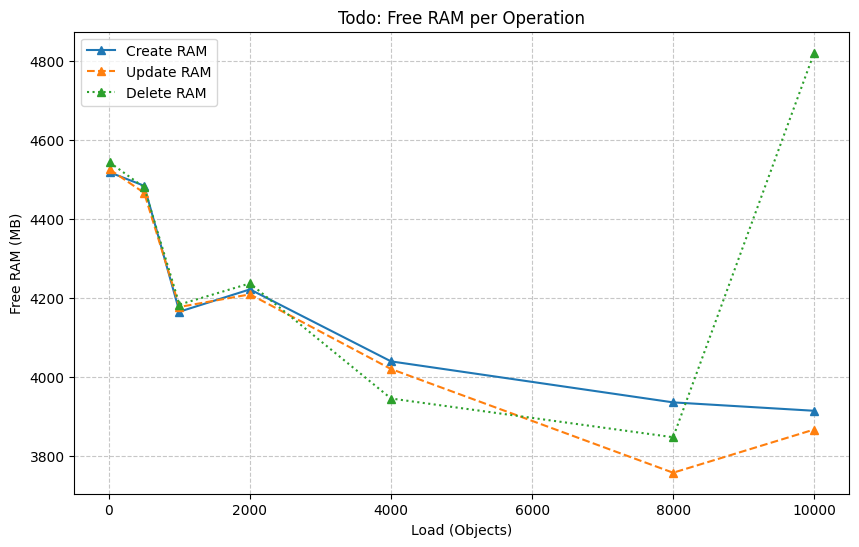

--- Generating Plots for Project ---


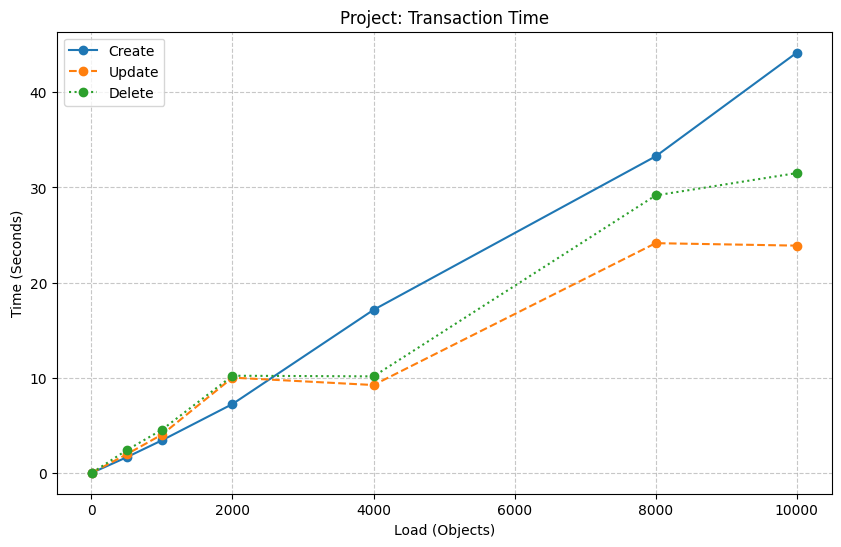

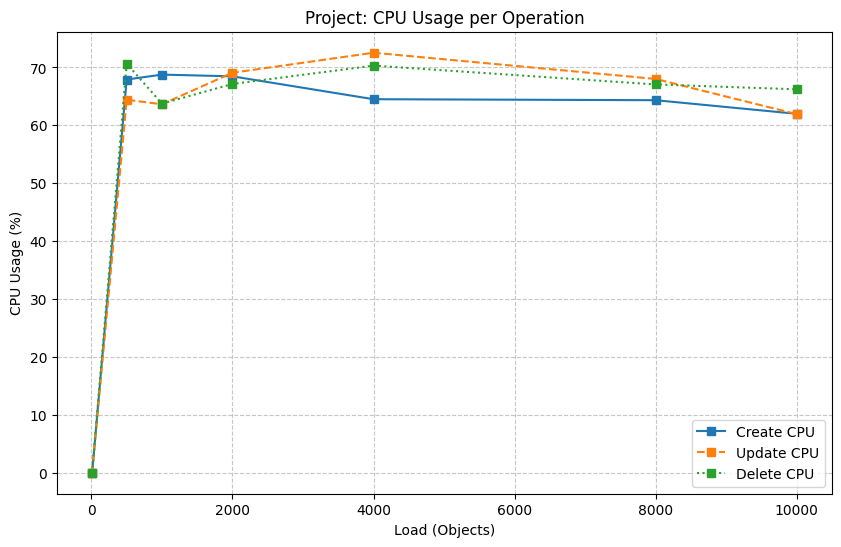

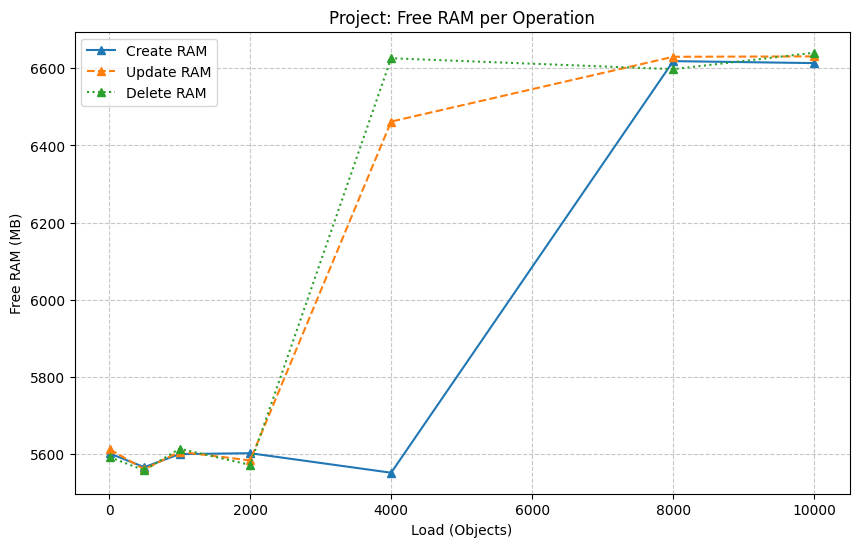

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure dataframe is ready
df_plot = pd.DataFrame(all_results) 
tester_types = df_plot['type'].unique()

# Loop through each tester type
for t_type in tester_types:
    # Filter data for this specific tester
    subset = df_plot[df_plot['type'] == t_type].sort_values('load_count')
    
    print(f"--- Generating Plots for {t_type} ---")

    # ==========================================
    # Graph 1: Transaction Times
    # ==========================================
    plt.figure(figsize=(10, 6))
    plt.plot(subset['load_count'], subset['create_time_sec'], marker='o', label='Create', linestyle='-')
    plt.plot(subset['load_count'], subset['update_time_sec'], marker='o', label='Update', linestyle='--')
    plt.plot(subset['load_count'], subset['delete_time_sec'], marker='o', label='Delete', linestyle=':')
    
    plt.title(f'{t_type}: Transaction Time')
    plt.ylabel('Time (Seconds)')
    plt.xlabel('Load (Objects)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

    # ==========================================
    # Graph 2: CPU Usage (Per Operation)
    # ==========================================
    plt.figure(figsize=(10, 6))
    
    # Check if we have the granular data available
    if 'create_cpu_avg' in subset.columns:
        plt.plot(subset['load_count'], subset['create_cpu_avg'], marker='s', label='Create CPU', linestyle='-')
        plt.plot(subset['load_count'], subset['update_cpu_avg'], marker='s', label='Update CPU', linestyle='--')
        plt.plot(subset['load_count'], subset['delete_cpu_avg'], marker='s', label='Delete CPU', linestyle=':')
        plt.ylabel('CPU Usage (%)')
        plt.title(f'{t_type}: CPU Usage per Operation')
    else:
        # Fallback to aggregate if granular data is missing
        plt.plot(subset['load_count'], subset['avg_cpu_percent'], marker='s', color='orange', label='Avg CPU')
        plt.ylabel('Avg CPU Usage (%)')
        plt.title(f'{t_type}: Average CPU Usage (Aggregated)')

    plt.xlabel('Load (Objects)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show() 

    # ==========================================
    # Graph 3: Free RAM (Per Operation)
    # ==========================================
    plt.figure(figsize=(10, 6))
    
    if 'create_ram_avg' in subset.columns:
        plt.plot(subset['load_count'], subset['create_ram_avg'], marker='^', label='Create RAM', linestyle='-')
        plt.plot(subset['load_count'], subset['update_ram_avg'], marker='^', label='Update RAM', linestyle='--')
        plt.plot(subset['load_count'], subset['delete_ram_avg'], marker='^', label='Delete RAM', linestyle=':')
        plt.ylabel('Free RAM (MB)')
        plt.title(f'{t_type}: Free RAM per Operation')
    else:
        # Fallback
        if 'avg_memory_free_mb' in subset.columns:
            plt.plot(subset['load_count'], subset['avg_memory_free_mb'], marker='^', color='green', label='Avg Free RAM')
            plt.ylabel('Free RAM (MB)')
            plt.title(f'{t_type}: Avg Free RAM (Aggregated)')
        else:
            plt.plot(subset['load_count'], subset['rel_mem_consumed_mb'], marker='^', color='red', label='Consumed RAM')
            plt.ylabel('Consumed RAM (MB)')
            plt.title(f'{t_type}: Rel Memory Consumed')
            
    plt.xlabel('Load (Objects)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()